In [2]:
import sys, os
from time import time
if '../' not in sys.path:
    sys.path.insert(0, '../')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from modules.paths import Experiment

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Load paths to each set of experiments
control_path = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/control/slices/w-eyFLP_PntGFP_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A'
mutant_path = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/perturbation/slices/w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A'
control = Experiment(control_path)
mutant = Experiment(mutant_path)

In [22]:
# Load individual disc
disc_id = 31
disc = control.discs[disc_id]
stack = disc.load_stack()

In [20]:
def show_layer(stack, layer_id=0):
    layer = stack.load_layer(layer_id)
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    _ = layer.get_channel('b').show(segments=False, ax=ax0, vmin=0, vmax=1)
    _ = layer.get_channel('r').show(segments=False, ax=ax1, vmin=0, vmax=1)
    _ = layer.get_channel('g').show(segments=False, ax=ax2, vmin=0, vmax=1)
    plt.tight_layout()

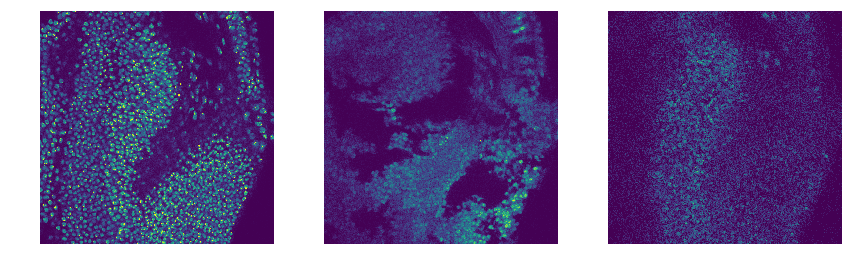

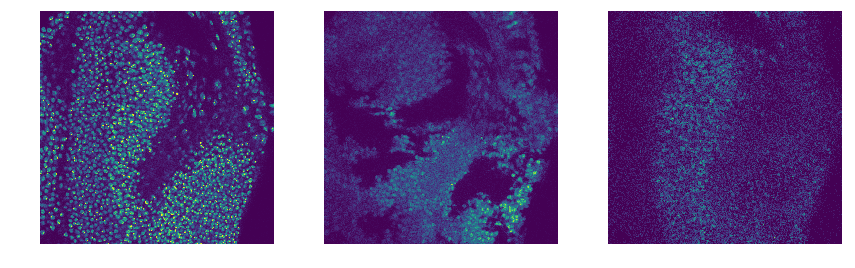

In [23]:
for layer_id in range(stack.depth):
    show_layer(stack, layer_id)

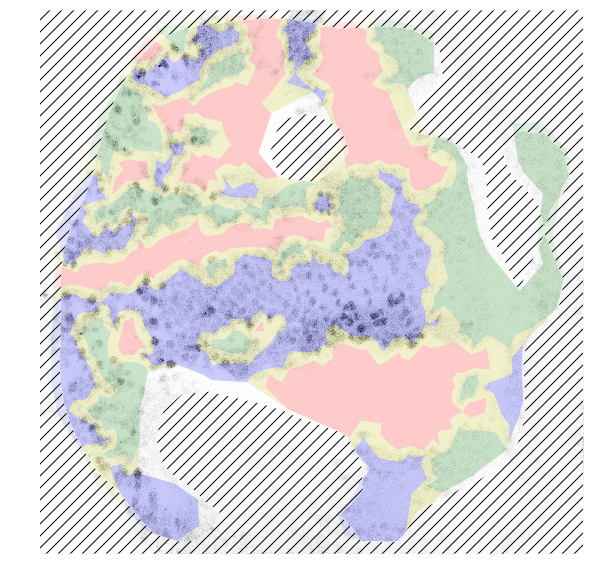

In [188]:
layer.annotate(channel='r_normalized', q=98, fg_only=True, upper_bound=100)
fig = layer.plot_annotation()

In [211]:
layer = stack.load_layer(0)

In [212]:
import infomap
import networkx as nx

In [213]:
channel = 'r'

layer.annotate(q=95, channel=channel, fg_only=False, upper_bound=100, log=True)
links = layer.annotation.graph.build_links(channel=channel)

im = layer.annotation.clustering.im.infomap


communities = {}
for node in im.iterLeafNodes():
    communities[node.physicalId] = node.moduleIndex()


# level = 3
# path_to_module = {}
# for m in im.iterModules():
#     if m.depth() == level:
#         path_to_module[m.path()] = m.moduleIndex()    
    
# communities = {}
# for i, node in enumerate(im.iterLeafNodes(1)):
#     if i == 0:
#         continue
#     communities[node.physicalId] = path_to_module[node.path()[:level]]
    
    # doesnt work after depth 1 because top node changes between paths!!

In [221]:
parse_link = lambda x,y,z: (x,y,dict(weight=z))
nx_edges = [parse_link(*link) for link in links]
G = nx.Graph()
G.add_edges_from(nx_edges)
nx.set_node_attributes(G, name='community', values=communities)

nx.set_node_attributes(G, name='genotype', values={i:g for i, g in enumerate(layer.annotation.clustering.genotypes)})

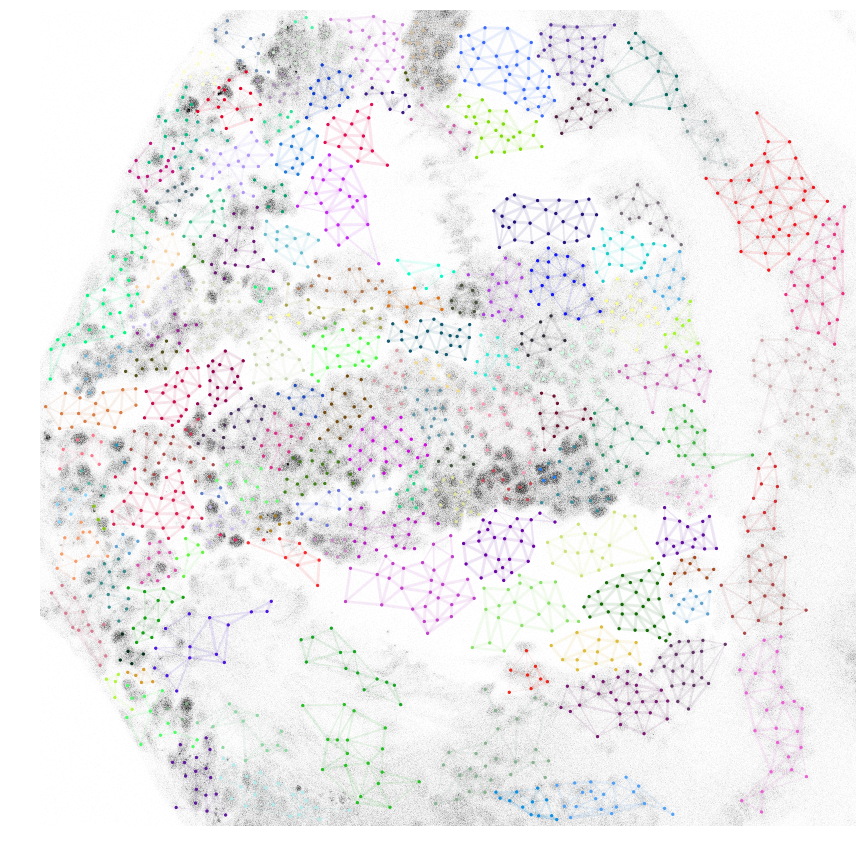

In [254]:
fig = layer.get_channel('r').show(segments=False, cmap=plt.cm.Greys, figsize=(15, 15))
pos = get_pos(layer)
_ = drawNetwork(G, pos, ax=fig.axes[0], alpha=1, edge_alpha=0.1, lw=3, node_size=5, colorby='community')

In [252]:
from matplotlib import colors

def get_pos(layer):
    g = layer.annotation.graph
    pos = {}
    for k in g.nodes:
        i = g.position_map(k)
        pos[k] = np.array([g.tri.x[i], g.tri.y[i]])
    return pos

def drawNetwork(G, pos, ax=None, alpha=1, edge_alpha=1, lw=1, node_size=20, colorby='genotype'):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 15))
    
    # position map
    #pos = nx.spring_layout(G, iterations=5)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    
    # color map from http://colorbrewer2.org/
    c = np.random.random(size=(numCommunities, 3))
    cmapLight = colors.ListedColormap(c, 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(c, 'indexed', numCommunities)

    # Draw edges
    get_weight = lambda G, u, v: G[u][v]['weight'] if G.node[u]['community']==G.node[v]['community'] else 0
    weights = [get_weight(G, u, v) for u,v in G.edges]
    edge_color = [cmapLight(G.node[u]['community']) for u,v in G.edges]
    #weights = [G[u][v]['weight'] for u,v in G.edges]
    norm = colors.Normalize(vmin=min(weights), vmax=max(weights))
    width = [norm(w)*lw for w in weights]
    nx.draw_networkx_edges(G, pos, ax=ax, width=width, alpha=edge_alpha, edge_color=edge_color)

    # Draw nodes
    if colorby == 'genotype':
        node_cmap = cmapLight
    else:
        node_cmap = cmapLight
    node_colors = [int(v) for k,v in nx.get_node_attributes(G, colorby).items()]
    nodeCollection = nx.draw_networkx_nodes(G,
        node_size=node_size,
        pos = pos,
        node_color = node_colors,
        alpha=alpha,
        cmap = node_cmap
    )
    # Set node border color to the darker shade
    #darkColors = [cmapDark(v) for v in communities]
    #nodeCollection.set_edgecolor(darkColors)


    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()
    
    return pos

In [247]:
type([v for k,v in nx.get_node_attributes(G, 'community').items()][0])

int

In [110]:
cmap = plt.cm.viridis

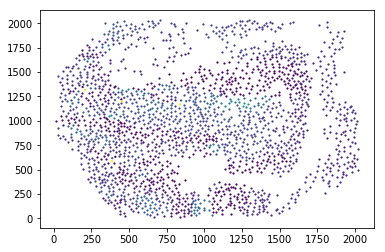

In [111]:
fig, ax = plt.subplots()

clusters = dict(r=[], r_normalized=[])
im_labels = layer.annotation.clustering.im_labels
for im_label in np.unique(im_labels):
    ind = layer.annotation.graph.nodes[np.where(im_labels==im_label)]
    nodes = layer.annotation.graph.df.loc[ind]
    xy = nodes[['centroid_y', 'centroid_x']].values
    c = cmap(nodes.r.mean())
    ax.scatter(*xy.T, c=c, s=5, linewidth=0)
    
    clusters['r'].append(nodes.r.mean())
    clusters['r_normalized'].append(nodes.r_normalized.mean())

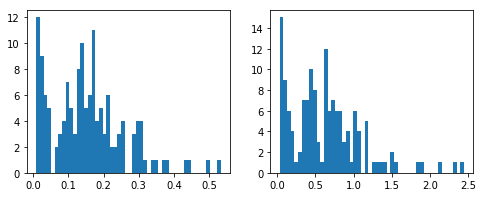

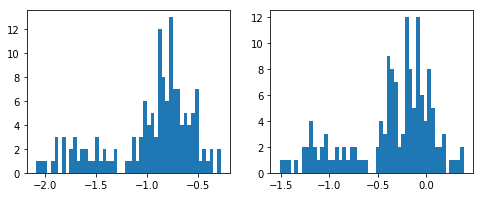

In [114]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))
_ = ax0.hist(clusters['r'], bins=50)
_ = ax1.hist(clusters['r_normalized'], bins=50)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))
_ = ax0.hist(np.log10(clusters['r']), bins=50)
_ = ax1.hist(np.log10(clusters['r_normalized']), bins=50)

In [ ]:
def groupby_clusters(layer):
    
    return


In [ ]:
fig, ax = plt.subplots()

clusters = dict(r=[], r_normalized=[])
im_labels = layer.annotation.clustering.im_labels
for im_label in np.unique(im_labels):
    ind = layer.annotation.graph.nodes[np.where(im_labels==im_label)]
    nodes = layer.annotation.graph.df.loc[ind]
    xy = nodes[['centroid_y', 'centroid_x']].values
    c = cmap(nodes.r.mean())
    ax.scatter(*xy.T, c=c, s=5, linewidth=0)
    
    clusters['r'].append(nodes.r.mean())
    clusters['r_normalized'].append(nodes.r_normalized.mean())

array([0.2012215 , 0.15966302, 0.21755332, 0.23643982, 0.13449662,
       0.13791217, 0.19808391, 0.1319309 , 0.15221066, 0.1366332 ,
       0.36946959, 0.09712756, 0.04742634, 0.10337881, 0.14390875,
       0.12954165, 0.07436099, 0.01485355, 0.15909369, 0.28661112,
       0.00820497, 0.06365737, 0.01052379, 0.11775034, 0.01328176,
       0.0222323 , 0.19102651, 0.04766769, 0.0898394 , 0.17343167,
       0.01962697, 0.08337245, 0.00911962, 0.03462365, 0.01283567,
       0.17960997, 0.31000868, 0.09660978, 0.03993706, 0.25470801,
       0.4935257 , 0.30528736, 0.09553428, 0.28383853, 0.09257142,
       0.19213584, 0.31093527, 0.1254837 , 0.21174937, 0.35271234,
       0.24868033, 0.07281609, 0.43003794, 0.29210739, 0.03298041,
       0.30198182, 0.13946036, 0.16953366, 0.18504134, 0.53334129,
       0.25823194, 0.21220174, 0.2495928 , 0.0883038 , 0.17126428,
       0.2541653 , 0.38202704, 0.14714089, 0.19564032, 0.26019312,
       0.17152433, 0.20662549, 0.10651006, 0.44679827, 0.02989

In [154]:
cluster_means = {}
for disc_id in control.disc_names:
    cluster_means[disc_id] = {}
    stack = control.discs[disc_id].load_stack()
    for layer_id in range(stack.depth):
        layer = stack.load_layer(layer_id)
        layer.annotate(q=95, channel=channel, fg_only=False, upper_bound=90)
        levels = layer.annotation.clustering.mean_cluster_levels
        cluster_means[disc_id][layer_id] = levels

In [163]:
all_levels = np.concatenate([np.concatenate(list(cluster_means[x].values())) for x in cluster_means.keys()])

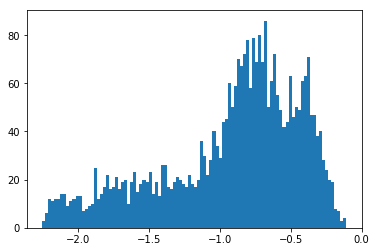

In [172]:
_ = plt.hist(np.log10(all_levels), bins=100)

In [167]:
from sklearn.cluster import k_means, mean_shift

In [209]:
def cluster(levels, log=False):
    
    if log:
        levels_clustered = np.log10(levels)
    else:
        levels_clustered = levels
    
    centroids, labels, _ = k_means(levels_clustered.reshape(-1, 1), 3)
    
    fig, ax = plt.subplots()
    bins = np.linspace(levels.min(), levels.max(), 100)
    for label in np.unique(labels):
        ax.hist(levels[labels==label], bins=bins)

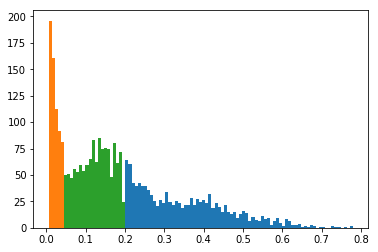

In [210]:
cluster(all_levels, log=True)

(array([[0.0581578 ],
        [0.44934292],
        [0.21036208]]),
 array([2, 2, 2, ..., 1, 1, 1], dtype=int32),
 10.321496573291357)